In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import nibabel as nb
import SimpleITK as sitk
from scipy.ndimage import zoom


import HeadCT_motion_correction_PAR.functions_collection as ff
import HeadCT_motion_correction_PAR.Data_processing as dp
import HeadCT_motion_correction_PAR.motion_simulator.motion_simulation.ct_basic as basic
import HeadCT_motion_correction_PAR.motion_simulator.transformation as transform

import CTProjector.src.ct_projector.projector.numpy as ct_projector
import CTProjector.src.ct_projector.projector.numpy.fan_equiangluar as ct_fan
import CMR_HFpEF_Analysis.motion_correction.Bspline as Bspline
main_path = '/mnt/mount_zc_NAS/head_phantom_raw/processed'

# load raw sinograms

In [2]:
# all studies:
# initial state
prjs4 = nb.load(os.path.join(main_path, 'study_4/scan4/processed_0/prjs_hann/projection_original.nii.gz')).get_fdata()
prjs4_reshape = np.transpose(prjs4,[0,2,1,3])
prjs4_reshape = np.reshape(prjs4_reshape, [prjs4_reshape.shape[0] * prjs4_reshape.shape[1], prjs4_reshape.shape[2], prjs4_reshape.shape[3]])

prjs3 = nb.load(os.path.join(main_path, 'study_4/scan3/processed_0/prjs_hann/projection_original.nii.gz')).get_fdata()
prjs3_reshape = np.transpose(prjs3,[0,2,1,3])
prjs3_reshape = np.reshape(prjs3_reshape, [prjs3_reshape.shape[0] * prjs3_reshape.shape[1], prjs3_reshape.shape[2], prjs3_reshape.shape[3]])

prjs5 = nb.load(os.path.join(main_path, 'study_4/scan5/processed_0/prjs_hann/projection_original.nii.gz')).get_fdata()
prjs5_reshape = np.transpose(prjs5,[0,2,1,3])
prjs5_reshape = np.reshape(prjs5_reshape, [prjs5_reshape.shape[0] * prjs5_reshape.shape[1], prjs5_reshape.shape[2], prjs5_reshape.shape[3]])

prjs6 = nb.load(os.path.join(main_path, 'study_4/scan6/processed_0/prjs_hann/projection_original.nii.gz')).get_fdata()
prjs6_reshape = np.transpose(prjs6,[0,2,1,3])
prjs6_reshape = np.reshape(prjs6_reshape, [prjs6_reshape.shape[0] * prjs6_reshape.shape[1], prjs6_reshape.shape[2], prjs6_reshape.shape[3]])


KeyboardInterrupt: 

# make motion-affected sinogram

In [31]:
study = 'study_0'
main_folder = os.path.join('/mnt/mount_zc_NAS/motion_correction/data/phantom_data', study)
motion_gt = np.load(os.path.join(main_folder, 'motion_each_point.npy'),allow_pickle = True)
motion_pred = np.load(os.path.join('/mnt/mount_zc_NAS/motion_correction/predict/phantom_data/images', study, 'parameters/pred_final.npy'), allow_pickle = True)

In [36]:
motion_pred[0,:] = np.array([-0.20887877, -0.330323  , -0.25350615,  0.15638308])

In [37]:
# get the spline function
# gt motion:
spline_tx_gt = transform.interp_func(np.linspace(0,100,25), np.asarray(motion_gt[0,:]))
spline_tz_gt = transform.interp_func(np.linspace(0,100,25), np.asarray(motion_gt[2,:]))
spline_rx_gt = transform.interp_func(np.linspace(0,100,25), np.asarray(motion_gt[3,:]))
spline_rz_gt = transform.interp_func(np.linspace(0,100,25), np.asarray(motion_gt[5,:]))

# pred motion
spline_tx_pred = transform.interp_func(np.linspace(0,100,5), np.concatenate([np.asarray([0]),motion_pred[0,:]],axis = -1))
spline_tz_pred = transform.interp_func(np.linspace(0,100,5), np.concatenate([np.asarray([0]),motion_pred[1,:]],axis = -1))
spline_rx_pred = transform.interp_func(np.linspace(0,100,5), np.concatenate([np.asarray([0]),motion_pred[2,:]],axis = -1))
spline_rz_pred = transform.interp_func(np.linspace(0,100,5), np.concatenate([np.asarray([0]),motion_pred[3,:]],axis = -1))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

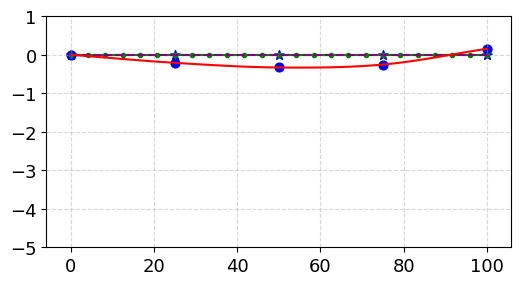

In [46]:
gt = motion_gt[0,:]
spline_gt = spline_tx_gt
spline_pred = spline_tx_pred

fig = plt.figure(figsize = (6,3))

t1 = np.linspace(0, 100, 5)

# gt motion
plt.plot(np.linspace(0, 100, 25), gt, color = 'green', marker ='.', label = 'gt_motion')

# gt B-spline
y_gt_cp = spline_gt(np.linspace(0,100,5))
plt.scatter(t1, y_gt_cp, s=50, color='blue', marker='*', label = 'gt_CP')
plt.plot(np.linspace(0,100, 100), transform.spline_motion_functions.interp(t1, y_gt_cp, np.linspace(0,100, 100)), color = 'purple', linestyle = '--', label = 'gt_B-spline')

# predict B-spline
pred_cp = spline_pred(np.linspace(0,100,5))
plt.scatter(t1, pred_cp, s=40, color='blue', marker='o', label = 'pred_CP')
plt.plot(np.linspace(0,100, 100),spline_pred(np.linspace(0,100,100)) , 'r-', linewidth = 2)

plt.yticks(np.arange(1, -5.1,step = -1),fontsize=13)
# plt.ylabel("mm or degree",fontsize=15)

plt.xticks(np.arange(0, 100.1,step = 20),fontsize=13)
# plt.xlabel("percent of gantry rotation time",fontsize=15)
      
plt.grid(True, linestyle='dashed', alpha=0.5)
save_path = '/mnt/mount_zc_NAS/motion_correction/pictures/Manuscript/phantom'
plt.savefig(os.path.join(save_path, 'tx.eps'), transparent = True)

In [8]:
# # divide sinogram in to 15 segments so it's divisible by 1440
# increment = 1440 // 15
# prjs_new = np.zeros_like(prjs4_reshape)

# t = np.linspace(0,100,15)

# for i in range( 0, 15):

#     tx = int(np.round(spline_tx_gt([t[i]])/0.601))
#     tz = spline_tz_gt([t[i]])
#     rz = spline_rz_gt([t[i]])

#     slice_index = [increment * i, increment * (i+1)]
   
#     if tx == 0:
#         p = np.copy(prjs4_reshape)
#         use = 4
#     elif tx == 1 or tx == 2:
#         p = np.copy(prjs3_reshape)
#         use = 3
#     elif tx == -2:
#         p = np.copy(prjs5_reshape)
#         use = 5
#     elif tx == -4:
#         p = np.copy(prjs6_reshape)
#         use = 6

#     p = dp.move_3Dimage(p, [int(np.round(-tz / 0.707)), int(np.round(rz/360 * 1440)),0])
#     print(i, slice_index, tx, 'sinogram use: ', use, -tz, np.round(-tz / 0.707) ,np.round(-tz / 0.707)*0.707 , rz, np.round(rz/360 * 1440),np.round(rz/360 * 1440)*0.25 )

#     prjs_new[:, slice_index[0]: slice_index[1], :] = p[:, slice_index[0]: slice_index[1], :]

# # save sinogram:
# nb.save(nb.Nifti1Image(prjs_new, nb.load(os.path.join(main_folder, 'projection.nii.gz')).affine), os.path.join(main_folder,'projection_HR_for_recon.nii.gz'))

0 [0, 96] [0.] sinogram use:  4 [-0.] [-0.] [-0.] [0.] [0.] [0.]
1 [96, 192] [0.] sinogram use:  4 [-0.05153061] [-0.] [-0.] [0.1712828] [1.] [0.25]
2 [192, 288] [0.] sinogram use:  4 [0.75646939] [1.] [0.707] [0.62026239] [2.] [0.5]
3 [288, 384] [0.] sinogram use:  4 [0.77708163] [1.] [0.707] [0.77259475] [3.] [0.75]
4 [384, 480] [0.] sinogram use:  4 [1.42018367] [2.] [1.414] [1.20116618] [5.] [1.25]
5 [480, 576] [-2.] sinogram use:  5 [1.83036735] [3.] [2.121] [2.053207] [8.] [2.]
6 [576, 672] [-2.] sinogram use:  5 [2.10038776] [3.] [2.121] [2.57142857] [10.] [2.5]
7 [672, 768] [-2.] sinogram use:  5 [2.828] [4.] [2.828] [3.] [12.] [3.]
8 [768, 864] [-2.] sinogram use:  5 [2.77646939] [4.] [2.828] [2.8287172] [11.] [2.75]
9 [864, 960] [-3.] sinogram use:  5 [3.58446939] [5.] [3.535] [2.37973761] [10.] [2.5]
10 [960, 1056] [-4.] sinogram use:  6 [3.60508163] [5.] [3.535] [2.22521866] [9.] [2.25]
11 [1056, 1152] [-4.] sinogram use:  6 [4.24818367] [6.] [4.242] [1.99781341] [8.] [2.]


In [15]:
# load sinogram
prjs_new = nb.load(os.path.join(main_folder,'projection_HR.nii.gz')).get_fdata()
print(prjs_new.shape)

(432, 1440, 448)


# make PAR-corrected

In [16]:
angles = ff.get_angles_zc(1440, 360, 0)

projector = ct_projector.ct_projector()
projector.from_file('./projector_fan_scanner.cfg')
projector.nv = 1
projector.nz = 1
projector.nx = 512
projector.ny = 512
projector.dx = 0.601
projector.dy = 0.601

slice1 = 0
slice2 = 180
projection = prjs_new[slice1:slice2,:,np.newaxis,:] #0-180, 180-380, 380-432
sinogram_segments, center_angle_index, num_angles_in_one_segment, segment_indexes = basic.divide_sinogram_new(projection, 7 ,1440 , fill_out = False)

In [17]:
# make PAR
num = sinogram_segments.shape[0]

PAR_collections = np.zeros([num, slice2 - slice1, 512,512])

for i in range(0,num):
    s = segment_indexes[i]
    segment = sinogram_segments[i,...]
    
    angles_partial = angles[s[0]:s[1]]

    # print(s, segment.shape, angles_partial.shape , angles_partial[0] / np.pi * 180, angles_partial[-1] / np.pi * 180)

    # backprojection
    recon = basic.filtered_backporjection(np.copy(segment, 'C'),angles_partial,projector,projector,'fan', back_to_original_value = False)
    recon = recon / 0.0193 * 1000 - 1000
    
    PAR_collections[i,:,:,:] = recon.astype(np.int32)

In [18]:
final_par_c = np.zeros_like(PAR_collections)

t = np.linspace(0,100,15)

for i in range(0, PAR_collections.shape[0]):
    # motion:
    tx = np.round(spline_tx_pred([t[i]]) / 0.601) * 0.601
    tz = np.round(spline_tz_pred([t[i]]) / 0.707)  * 0.707
    rz = np.round(spline_rz_pred([t[i]]) / 0.25)  * 0.25

    I = PAR_collections[i,...]
    _,_,_,transformation_matrix = transform.generate_transform_matrix([-tz / 0.707  , -tx  / 0.601, 0 ],[-rz / 180 * np.pi, 0,0],[1,1,1],I.shape, which_one_is_first='translation')
    transformation_matrix = transform.transform_full_matrix_offset_center(transformation_matrix, I.shape)
    final_par_c[i,...] = transform.apply_affine_transform(I, transformation_matrix,order = 3, cval = np.min(I))

    print('done transformation: ',i, tx, tz, rz)

/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/workspace/Documents/HeadCT_motion_correction_PAR/motion_simulator/transformation/rotation_matrix_from_angle.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(


done transformation:  0 [0.] [0.] [0.]
done transformation:  1 [0.] [-0.707] [0.25]
done transformation:  2 [0.] [-0.707] [0.5]


KeyboardInterrupt: 

In [8]:
par_corrected_image_0_180 = np.mean(final_par_c,axis=0)

In [10]:
img_0_180 = np.copy(par_corrected_image_0_180)

In [9]:
img_180_380 = np.copy(par_corrected_image_180_380)

In [20]:
img_380_432 = np.copy(par_corrected_image_380_432)

In [11]:
img = np.zeros([432,512,512])
img[0:180,...] = img_0_180
img[180:380,...] = img_180_380
img[380:432,...] = img_380_432

img_average = np.zeros([img.shape[0] // 4, img.shape[1], img.shape[2]])
for i in range(0,img.shape[0] // 4):
    img_average[i,...] = np.mean(img[(4 * i) : (4 * i + 4),...], axis = 0)

img_average = img_average.astype(np.int16)

sitk_recon = sitk.GetImageFromArray(img_average)
sitk_recon.SetSpacing([0.6016,0.6016, 2.828])
sitk.WriteImage(sitk_recon, os.path.join(main_folder, 'PAR_corrected_HRxy.nii.gz')) 


then run ring artifact removal

In [27]:
# after ring-artifact-removal:
study = 'study_10'
main_folder = os.path.join('/mnt/mount_zc_NAS/motion_correction/data/phantom_data', study)

filepath = os.path.join(main_folder, 'PAR_corrected_HRxy_ibc_idr.nii.gz')
a = sitk.ReadImage(filepath)
b = sitk.GetArrayFromImage(a)
par_corrected_image = zoom(b,[1,0.601,0.601])

sitk_recon = sitk.GetImageFromArray(par_corrected_image[45:95,:,:])
sitk_recon.SetSpacing([1,1,2.828])
sitk.WriteImage(sitk_recon, os.path.join(main_folder, 'PAR_corrected_ibc_idr.nii.gz'))

# Compare

In [68]:
par_results = nb.load(os.path.join(main_folder, 'PAR_corrected_ibc_idr.nii.gz')).get_fdata()[:,:,10:50]

cnn_results = nb.load(os.path.join('/mnt/mount_zc_NAS/motion_correction/predict/phantom_data/images/',study, 'pred_CNN.nii.gz')).get_fdata()[:,:,10:50]

static = nb.load('/mnt/mount_zc_NAS/head_phantom_raw/processed/study_4/scan4/processed_0/recon_cropped/recon_ibc_idr_partial.nii.gz').get_fdata()[:,:,10:50]

move = nb.load(os.path.join(main_folder, 'simulated_imgs_resampled/recon_motion_ibc_idr_partial.nii.gz')).get_fdata()[:,:,10:50]

In [69]:
mae, mse, rmse, r_rmse, ssim = ff.compare(move, static, cutoff_low=-10)
print(mae, rmse, ssim)

mae, mse, rmse, r_rmse, ssim = ff.compare(cnn_results, static, cutoff_low=-10)
print(mae, rmse, ssim)

mae, mse, rmse, r_rmse, ssim = ff.compare(par_results, static, cutoff_low=-10, extreme = 900)
print(mae, rmse, ssim)

133.51390618164925 279.0894466972709 0.7530276501417535
52.68155900743444 131.98286579607085 0.935793504875761
95.70260915919522 206.14442438030264 0.8604510135310337
